# 2.0 - Geneset Graphs for community detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

In [2]:
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from src.ssGSEA.ssGSEA_related import get_GSEA_genesets

In [3]:
import networkx as nx
from cdlib.algorithms import infomap, sbm_dl, louvain, label_propagation
from src.utils.constants import TCGA_DATASETS
from tqdm import tqdm

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy'}


Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}


In [4]:
raw_expression_data = pd.read_csv("../tcga-data/data/raw/TCGA-CESC.csv", index_col=[0])
ensembl_to_symbol_mapping = pd.read_csv("../tcga-data/data/gene_mapping.csv", index_col=[0]).to_dict()["gene_name"]

In [5]:
GENESETS = "GO-BiologicalProcess"
GENESET_FILENAME = "c5.go.bp.v2023.1.Hs.symbols.gmt"

rmst_scores = pd.read_csv(f"../data/{GENESETS}/rmst-difference-scores.tsv", sep="\t", index_col=[0])
logrank_pval = pd.read_csv(f"../data/{GENESETS}/logrank-scores-p-value.tsv", sep="\t", index_col=[0])

genesets_info_tcga = {
    tcga: {
        g: [set(v), len(v)]
        for g, v in get_GSEA_genesets(
            pd.read_csv(f"../tcga-data/data/TCGA-{tcga}.csv", index_col=[0]).columns,
            filename=GENESET_FILENAME, dir="../").items()
    }
    for tcga in tqdm(TCGA_DATASETS)
}

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [01:05<00:00,  3.46s/it]


## Jaccard distance

In [6]:
def calculate_jaccard_distance(geneset_subset:list, genesets_info:dict):

    jaccard_distance = np.ones((len(geneset_subset), len(geneset_subset)))

    for i in range(len(geneset_subset)-1):
        for j in range(i+1, len(geneset_subset)):
            
            inter = len(genesets_info[geneset_subset[i]][0].intersection(genesets_info[geneset_subset[j]][0]))
            union = genesets_info[geneset_subset[i]][1] + genesets_info[geneset_subset[j]][1] - inter

            iou = inter/union
            
            jaccard_distance[i][j] = iou
            jaccard_distance[j][i] = iou
    
    return pd.DataFrame(jaccard_distance, index=geneset_subset, columns=geneset_subset)

def calculate_weighted_jaccard_distance(geneset_subset:list, genesets_info:dict, gene_weights:dict):

    jaccard_distance = np.ones((len(geneset_subset), len(geneset_subset)))

    weighted_genesets_info = {
        g: [v[0], np.sum([gene_weights[i] for i in v[0]])]
        for g, v in genesets_info.items()
        if g in geneset_subset
    }

    for i in range(len(geneset_subset)-1):
        for j in range(i+1, len(geneset_subset)):
            
            inter_set = weighted_genesets_info[geneset_subset[i]][0].intersection(weighted_genesets_info[geneset_subset[j]][0])
            inter = np.sum([gene_weights[i] for i in inter_set])
            union = genesets_info[geneset_subset[i]][1] + genesets_info[geneset_subset[j]][1] - inter

            iou = inter/union
            
            jaccard_distance[i][j] = iou
            jaccard_distance[j][i] = iou
    
    return pd.DataFrame(jaccard_distance, index=geneset_subset, columns=geneset_subset)

def get_gene_weights(raw_expression_data:pd.DataFrame, ensembl_to_symbol_mapping:dict):

    weights = raw_expression_data.std()/raw_expression_data.mean()
    weights.index = [ensembl_to_symbol_mapping[g] for g in weights.index.values]

    return weights.to_dict()

def calculate_gene_inclusion(geneset_subset:list, genesets_info:dict, gene_weights:dict=None):

    all_genes = np.unique([i for x in [genesets_info[g][0] for g in geneset_subset] for i in x])
    
    if gene_weights is not None:
        gene_weights_vector = np.array([gene_weights[i] for i in all_genes])

    data = np.zeros((len(geneset_subset), len(all_genes)))

    for j, g in enumerate(geneset_subset):
        genes = genesets_info[g][0]

        in_genes = [1 if x in genes else 0 for x in all_genes]

        if gene_weights is not None:
            in_genes *= gene_weights_vector
        
        data[j] = in_genes
    
    return pd.DataFrame(data, index=geneset_subset, columns=all_genes)

In [7]:
weights = get_gene_weights(raw_expression_data, ensembl_to_symbol_mapping)

## Genesets into Graph

In [8]:
def load_tcga_geneset_results(GENESETS:str, N_NODES_MAX:int, N_NODES_MIN:int, p_val_threshold: float, genesets_info:dict, weights:dict=None):
    
    logrank_pval = pd.read_csv(f"../data/{GENESETS}/logrank-scores-p-value.tsv", sep="\t", index_col=[0]).fillna(1)
    
    results = {}

    for tcga in TCGA_DATASETS:
        geneset_subset = pd.Series(ss.false_discovery_control(logrank_pval[tcga]), index=logrank_pval[tcga].index, name=tcga)
        geneset_subset = geneset_subset[geneset_subset < p_val_threshold].sort_values().iloc[:N_NODES_MAX].index.values

        if len(geneset_subset) < N_NODES_MIN:
            continue

        results[tcga] = (
            calculate_jaccard_distance(geneset_subset, genesets_info[tcga])
            if weights is None else
            calculate_weighted_jaccard_distance(geneset_subset, genesets_info[tcga], weights)
        )
    
    return results

N_MAX_NODES = 200
P_VAL_THRESHOLD = 0.05
N_MIN_NODES = 50

tcga_jaccard_df = load_tcga_geneset_results(GENESETS, N_MAX_NODES, N_MIN_NODES, P_VAL_THRESHOLD, genesets_info_tcga)
tcga_weighted_jaccard_df = load_tcga_geneset_results(GENESETS, N_MAX_NODES, N_MIN_NODES, P_VAL_THRESHOLD, genesets_info_tcga, weights)

### Construct Adjecency matrix

In [9]:
def construct_tcga_graphs(dataset_jaccard_df:dict, MIN_LINKS:int=0, average_degree:float=4.0):

    dataset_graphs = {}

    for tcga in dataset_jaccard_df.keys():

        adj_mtx = dataset_jaccard_df[tcga].values.copy()

        # add min_links
        remember_links = []
        for i in range(adj_mtx.shape[0]):
            ranks = len(adj_mtx) - np.argsort(np.argsort(adj_mtx[i]))
            ranks += len(adj_mtx)*(adj_mtx[i] <= 0)
            ids = np.where(ranks <= MIN_LINKS+1)[0].flatten()
            remember_links += [(i, ids)]
        
        for i, ids in remember_links:
            adj_mtx[i, ids] = 1
            adj_mtx[ids, i] = 1
        
        adj_mtx[np.arange(len(adj_mtx)), np.arange(len(adj_mtx))] = 0

        N_nodes = len(adj_mtx)
        N_links = N_nodes * average_degree / 2
        similarity_threshold = np.quantile(adj_mtx.flatten(), 1 - 2 * N_links/(N_nodes * (N_nodes - 1)))

        if similarity_threshold <= 0:
            continue

        adj_mtx = (adj_mtx >= similarity_threshold).astype(int)

        dataset_graphs[tcga] = nx.from_pandas_adjacency(
            pd.DataFrame(adj_mtx, index=dataset_jaccard_df[tcga].index, columns=dataset_jaccard_df[tcga].index)
        )
    
    return dataset_graphs

MIN_LINKS = 0
AVERAGE_DEGREE = 8

dataset_graphs = {}
dataset_graphs["jaccard"] = construct_tcga_graphs(tcga_jaccard_df, MIN_LINKS, AVERAGE_DEGREE)
dataset_graphs["weighted"] = construct_tcga_graphs(tcga_weighted_jaccard_df, MIN_LINKS, AVERAGE_DEGREE)

### Connect with threshold on similarity

In [10]:
# preprocessing for graphs
layout_seed = 3

graph_layout = {
    jac: {   
        tcga: nx.spring_layout(G, seed=layout_seed)
        for tcga, G in ds_graphs.items()
    }
    for jac, ds_graphs in dataset_graphs.items()
}

graph_cc = {
    jac: {   
        tcga: G.subgraph(max(nx.connected_components(G), key=lambda x: len(x)))
        for tcga, G in ds_graphs.items()
    }
    for jac, ds_graphs in dataset_graphs.items()
}

graph_infomap = {
    jac: {   
        tcga: infomap(G).communities
        for tcga, G in ds_graphs.items()
    }
    for jac, ds_graphs in dataset_graphs.items()
}

graph_infomap_cc = {
    jac: {   
        tcga: infomap(G).communities
        for tcga, G in ds_graphs.items()
    }
    for jac, ds_graphs in graph_cc.items()
}

In [11]:
color_list = ["royalblue", "red", "forestgreen", "orange", "k"]
N_communities = len(color_list) # communities to plot
N_datasets = len(dataset_graphs["jaccard"])
JACCARD = "jaccard"

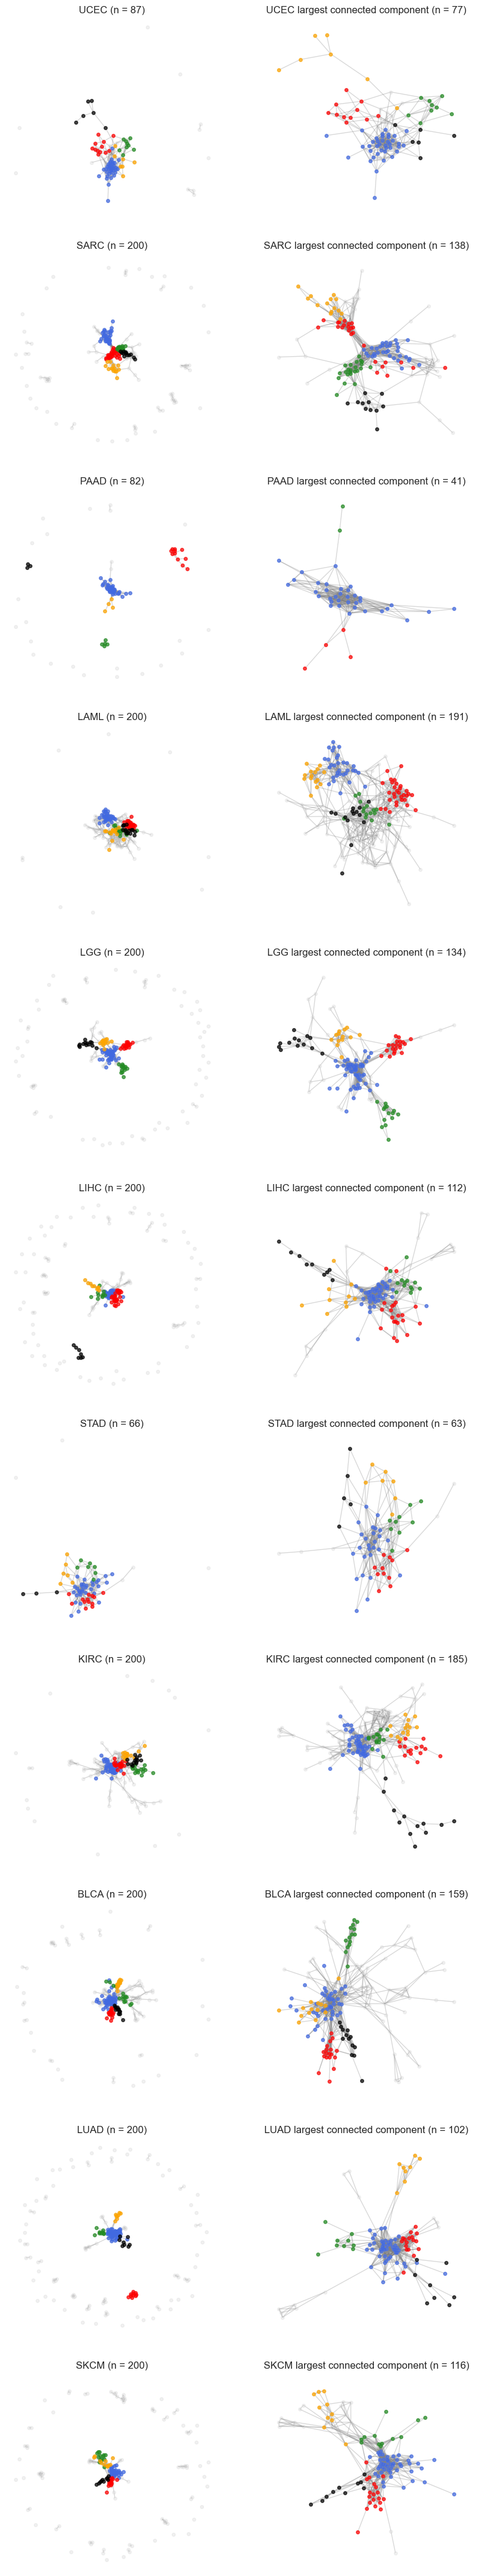

In [12]:
NODE_SIZE = 15

f, ax = plt.subplots(N_datasets, 2, figsize=(10, N_datasets*5))

for i, tcga in enumerate(dataset_graphs[JACCARD].keys()):
    
    for j, G in enumerate([dataset_graphs[JACCARD][tcga], graph_cc[JACCARD][tcga]]):
        nx.draw_networkx(
            G, graph_layout[JACCARD][tcga], with_labels=False,
            node_color="lightgray", edge_color="gray", node_size=NODE_SIZE, alpha=0.3,
            ax=ax[i][j])
        
        for loc in ["right", "left", "top", "bottom"]:
            ax[i][j].spines[loc].set_visible(False)
        
        ax[i][j].set_title(f"{tcga}" + (" largest connected component" if j==1 else "") + f" (n = {len(G)})", fontsize=12)


        for k, com in enumerate(graph_infomap[JACCARD][tcga][:N_communities] if j == 0 else graph_infomap_cc[JACCARD][tcga][:N_communities]):
            
            nx.draw_networkx_nodes(
                G, graph_layout[JACCARD][tcga], node_color=color_list[k],
                nodelist=[x for x in com if x in G.nodes()], node_size=NODE_SIZE,
                ax=ax[i][j], alpha=0.7
            )
        
        ax[i][j].grid(False)

f.savefig(f"../figures/geneset_clustering_{JACCARD}-nostd.pdf", dpi=300, bbox_inches="tight")

## Individual Graph

In [32]:
def xy_for_community_text(layout, com, times:int=1):

    com_mean = np.median(np.concatenate([v.reshape(1,-1) for k, v in layout.items() if k in com]), axis=0)
    rest_mean = np.median(np.concatenate([v.reshape(1,-1) for k, v in layout.items() if k not in com],), axis=0)
    all_mean = np.median(np.concatenate([v.reshape(1,-1) for k, v in layout.items()]), axis=0)

    diff = com_mean - rest_mean
    norm = diff/np.linalg.norm(diff, 2)
    return all_mean + norm*times, diff

com_names_lgg = {
    0: "SOX9 overexpression\npromoting glioma metastasis\nvia Wnt/β-catenin signaling",
    1: "Promoting malignancy\nvia TP53 mutations",
    2: "Markers of rapid cytokinesis,\nsuch as higher expression of CENPE,\nESCRT-III complex, PSRC1, etc.",
    3: "Platelet-derived growth factor (PDGF)\n related tumour growth",
}

### LGG

royalblue
['GOBP_SKIN_DEVELOPMENT', 'GOBP_SKELETAL_SYSTEM_DEVELOPMENT', 'GOBP_MORPHOGENESIS_OF_A_BRANCHING_STRUCTURE', 'GOBP_APOPTOTIC_PROCESS', 'GOBP_NEGATIVE_REGULATION_OF_CELL_DEATH', 'GOBP_CELLULAR_PROCESS_INVOLVED_IN_REPRODUCTION_IN_MULTICELLULAR_ORGANISM', 'GOBP_OOGENESIS', 'GOBP_REGULATION_OF_CELL_DEATH', 'GOBP_REGULATION_OF_TRANSFERASE_ACTIVITY', 'GOBP_VASCULATURE_DEVELOPMENT', 'GOBP_REGULATION_OF_ORGANELLE_ORGANIZATION', 'GOBP_NEGATIVE_REGULATION_OF_PROTEIN_METABOLIC_PROCESS', 'GOBP_EMBRYONIC_MORPHOGENESIS', 'GOBP_TUBE_DEVELOPMENT', 'GOBP_MALE_GAMETE_GENERATION', 'GOBP_CONNECTIVE_TISSUE_DEVELOPMENT', 'GOBP_OOCYTE_MATURATION', 'GOBP_MULTICELLULAR_ORGANISM_REPRODUCTION', 'GOBP_TUBE_MORPHOGENESIS', 'GOBP_CELL_PROJECTION_ASSEMBLY', 'GOBP_OSTEOBLAST_DIFFERENTIATION', 'GOBP_CIRCULATORY_SYSTEM_DEVELOPMENT', 'GOBP_REGULATION_OF_REPRODUCTIVE_PROCESS', 'GOBP_BONE_MORPHOGENESIS', 'GOBP_BONE_DEVELOPMENT', 'GOBP_SKELETAL_SYSTEM_MORPHOGENESIS', 'GOBP_FEMALE_GAMETE_GENERATION', 'GOBP_SEXUAL_

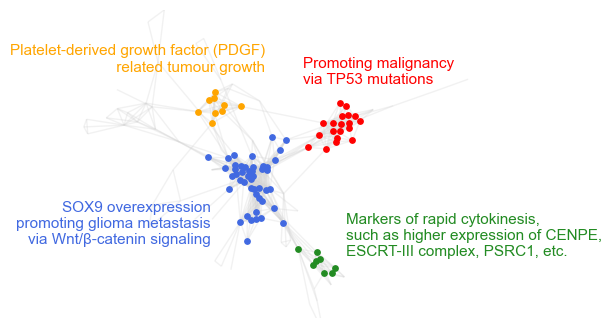

In [36]:
JACCARD = "jaccard"
tcga = "LGG"

f, ax = plt.subplots(1, 1, figsize=(6,4))

nx.draw_networkx(
    graph_cc[JACCARD][tcga], graph_layout[JACCARD][tcga], with_labels=False,
    node_color="lightgray", edge_color="lightgray", node_size=0, alpha=0.3,
    ax=ax)

for loc in ["right", "left", "top", "bottom"]:
    ax.spines[loc].set_visible(False)

#ax.set_title(f"{tcga}" + (" largest connected component" if j==1 else "") + f" (n = {len(graph_cc[JACCARD][tcga])})", fontsize=12)

for k, com in enumerate(graph_infomap_cc[JACCARD][tcga][:4]):
    
    nodelist = [x for x in com if x in graph_cc[JACCARD][tcga].nodes()]

    G_ = nx.k_core(graph_cc[JACCARD][tcga].subgraph(nodelist), 5)

    nx.draw_networkx_nodes(
        graph_cc[JACCARD][tcga], graph_layout[JACCARD][tcga], node_color=color_list[k],
        nodelist=nodelist, node_size=NODE_SIZE,
        ax=ax, alpha=0.0
    )

    
    for name in G_.nodes():
        nx.draw_networkx_nodes(
            G_, graph_layout[JACCARD][tcga], node_color=color_list[k], node_size=NODE_SIZE,
            ax=ax, alpha=1, nodelist=[name], #node_shape="^" if rmst_scores.loc[name, tcga] > 0 else "s"
        )

    print(color_list[k])
    print(G_.nodes())
    print()

ax.grid(False)

interesting_coms = np.arange(4)

com_loc = {
    0: [-0.1, -0.13, "right"],
    1: [0.07, 0.13, "left"],
    2: [0.15, -0.15, "left"],
    3: [0, 0.15, "right"],
    
}
for i in interesting_coms:
    #xy, diff = xy_for_community_text(graph_layout[JACCARD][tcga], graph_infomap_cc[JACCARD][tcga][i], times=0.25)
    
    ax.text(com_loc[i][0], com_loc[i][1], com_names_lgg[i], color=color_list[i], fontsize=11,
            horizontalalignment=com_loc[i][2])
            #verticalalignment="right" if diff[1] > 0 else "left")


ax.set_ylim(-0.25, 0.25)
f.savefig(f"../figures/GO-clustering-{tcga}-labeled.pdf", dpi=500, bbox_inches="tight")

In [28]:
com_genes = {}
for k, com in enumerate(graph_infomap_cc[JACCARD][tcga][:5]):
    
    nodelist = [x for x in com if x in graph_cc[JACCARD][tcga].nodes()]
    G_ = nx.k_core(graph_cc[JACCARD][tcga].subgraph(nodelist), 5)
    print(sorted(G_.degree, key=lambda x: x[1], reverse=True))
    com = list(G_.nodes())
    print(k, len(com))
    print()
    genes = [
        genesets_info_tcga["KIRC"][x][0]
        for x in com
    ]
    com_genes[k] = [i for x in genes for i in x]

[('GOBP_DEVELOPMENTAL_PROCESS_INVOLVED_IN_REPRODUCTION', 34), ('GOBP_TUBE_DEVELOPMENT', 33), ('GOBP_CIRCULATORY_SYSTEM_DEVELOPMENT', 33), ('GOBP_REPRODUCTION', 33), ('GOBP_ANATOMICAL_STRUCTURE_FORMATION_INVOLVED_IN_MORPHOGENESIS', 33), ('GOBP_EPITHELIUM_DEVELOPMENT', 33), ('GOBP_TUBE_MORPHOGENESIS', 31), ('GOBP_NEGATIVE_REGULATION_OF_CELL_DEATH', 30), ('GOBP_REGULATION_OF_CELL_DEATH', 28), ('GOBP_VASCULATURE_DEVELOPMENT', 28), ('GOBP_MULTICELLULAR_ORGANISM_REPRODUCTION', 28), ('GOBP_EPITHELIAL_CELL_DIFFERENTIATION', 28), ('GOBP_APOPTOTIC_PROCESS', 27), ('GOBP_EMBRYONIC_MORPHOGENESIS', 27), ('GOBP_GLAND_DEVELOPMENT', 26), ('GOBP_MUSCLE_STRUCTURE_DEVELOPMENT', 25), ('GOBP_OSSIFICATION', 25), ('GOBP_EPITHELIAL_TUBE_MORPHOGENESIS', 25), ('GOBP_SKELETAL_SYSTEM_DEVELOPMENT', 24), ('GOBP_MORPHOGENESIS_OF_A_BRANCHING_STRUCTURE', 23), ('GOBP_CYTOSKELETON_ORGANIZATION', 22), ('GOBP_NEGATIVE_REGULATION_OF_PROTEIN_METABOLIC_PROCESS', 21), ('GOBP_SEXUAL_REPRODUCTION', 21), ('GOBP_REGULATION_OF_TRAN

In [29]:
for key, genes in list(com_genes.items())[:1]:    
    u, c = np.unique(com_genes[key], return_counts=True)
    data = pd.Series(c, index=u).sort_values(ascending=False).head(20)
    print(key)
    print([(u,c) for u, c in zip(data.index.values, data.values)])
    print(data.index.values)
    print()
    gs = data.index.values

0
[('CTNNB1', 36), ('BMP4', 34), ('SRC', 33), ('EDN1', 31), ('IHH', 30), ('SOX9', 30), ('AKT1', 28), ('NOTCH1', 28), ('NPR2', 27), ('SMAD4', 27), ('SFRP1', 27), ('MDK', 26), ('RARA', 26), ('TNF', 26), ('SHH', 25), ('FOXC1', 25), ('SFRP2', 25), ('WNT5A', 25), ('FGFR2', 25), ('MSX2', 24)]
['CTNNB1' 'BMP4' 'SRC' 'EDN1' 'IHH' 'SOX9' 'AKT1' 'NOTCH1' 'NPR2' 'SMAD4'
 'SFRP1' 'MDK' 'RARA' 'TNF' 'SHH' 'FOXC1' 'SFRP2' 'WNT5A' 'FGFR2' 'MSX2']

